In [618]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy import stats

from tpot import TPOTRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 0

In [619]:
CARPETA_DATOS_ORIGINALES = 'Datos/Limpios/'
DF_VALORACION= pd.read_csv(os.path.join(CARPETA_DATOS_ORIGINALES, 'df_valoracion.csv'))

In [620]:
DF_VALORACION.columns

Index(['Precio/Venta', 'Activo circulante mil EUR_2021',
       'Fondos propios mil EUR_2021', 'Total activo mil EUR_2021',
       'Total pasivo y capital propio mil EUR_2021',
       'Fondo de maniobra mil EUR_2021', 'Deudores mil EUR_2021',
       'Ingresos de explotacion mil EUR_2021',
       'Importe neto Cifra de Ventas mil EUR_2021',
       'Pasivo liquido mil EUR_2021', 'Total pasivo_2021', 'total_funding',
       'Pasivo fijo mil EUR_2021', 'Gastos financieros mil EUR_2021',
       'Resultado Explotacion mil EUR_2021', 'EBIT mil EUR_2021',
       'Precio/Ebit', 'Resultado del Ejercicio mil EUR_2021',
       'Result. ordinarios antes Impuestos mil EUR_2021',
       'Importe neto Cifra de Ventas mil EUR_ratio', 'valuation_2022'],
      dtype='object')

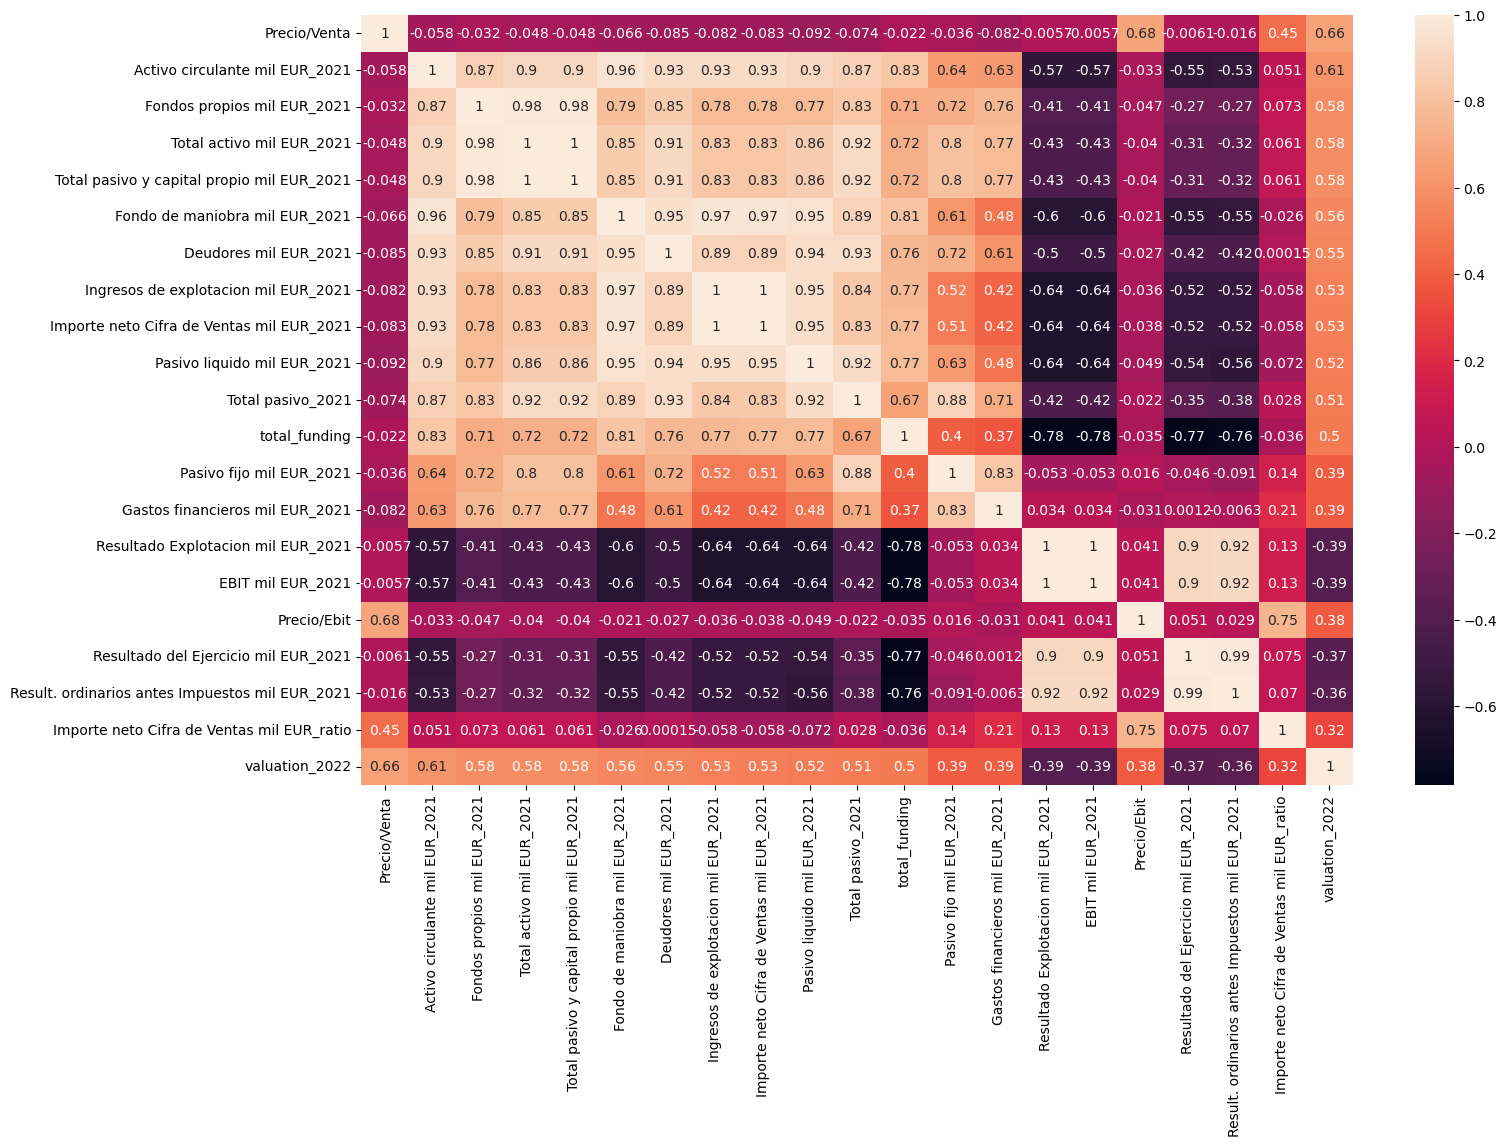

In [621]:
corr = DF_VALORACION.corr()
c=plt.figure(figsize=(16,10))
sns.heatmap(corr, annot=True)
plt.show()

In [622]:
corr_matrix = DF_VALORACION.corr()

# creating a boolean mask that indicates variables with correlation greater than 0.49 with 'valuation_2022'
mask = corr_matrix['valuation_2022'].abs() > 0.49

# selecting only the columns that satisfy the boolean mask
selected_columns = DF_VALORACION.loc[:, mask].columns

# creating a new DataFrame with the selected variables
DF_VALORACION = DF_VALORACION.loc[:, selected_columns].copy()

In [623]:
DF_VALORACION.shape

(60, 13)

In [624]:
y=DF_VALORACION['valuation_2022']

In [625]:
x=DF_VALORACION.loc[:, DF_VALORACION.columns !='valuation_2022']

In [626]:
x.shape

(60, 12)

In [627]:
# se dividen los datos en train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [628]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((54, 12), (6, 12), (54,), (6,))

In [629]:
#Creamos carpeta para guardar algunos modelos de alta duración.
modelos="./modelos_regresion"
if not os.path.exists(modelos):
    os.makedirs(modelos)

Escalar modo 1

In [630]:
y_train_transformed, lambda_ = stats.boxcox(y_train + 1)

# calcular la media y la desviación estándar de los datos transformados
y_train_transformed_mean = np.mean(y_train_transformed)
y_train_transformed_std = np.std(y_train_transformed)

# estandarizar los datos transformados
y_train_scaled = (y_train_transformed - y_train_transformed_mean) / y_train_transformed_std

In [631]:
# entrenar el modelo en los datos de entrenamiento con validación cruzada
model = LinearRegression()
scores = cross_val_score(model, x_train, y_train_scaled, cv=5, scoring='neg_mean_absolute_error')
avg_mae1 = -scores.mean()

# ajustar el modelo a todos los datos de entrenamiento
model.fit(x_train, y_train_scaled)

# hacer predicciones en los datos de prueba y desescalar las predicciones
y_pred_scaled = model.predict(x_train)
y_pred_descaled_transformed = y_pred_scaled * y_train_transformed_std + y_train_transformed_mean
y_pred = stats.boxcox(y_pred_descaled_transformed + 1, lmbda=1/lambda_)
y_pred -= 1

# evaluar el modelo en los datos de prueba
mae1 = mean_absolute_error(y_train, y_pred)
r21 = r2_score(y_train, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae1}")
print(f"MAE: {mae1}")
print(f"R^2: {r21}")

Cross-validation MAE: 1.259334094035525
MAE: 16.722945670081906
R^2: -0.2645738187866651


Escalar modo 2

In [632]:
#Escalamos los datos de train
y_train_log = np.log(y_train + 1)

# Calcular la media y la desviación estándar de los datos transformados
log_mean = np.mean(y_train_log)
log_std = np.std(y_train_log)

# Estandarizar los datos transformados
y_train_scaled = (y_train_log - log_mean) / log_std

In [633]:
# entrenar el modelo en los datos de entrenamiento con validación cruzada
model = LinearRegression()
scores = cross_val_score(model, x_train, y_train_scaled, cv=5, scoring='neg_mean_absolute_error')
avg_mae1 = -scores.mean()

# ajustar el modelo a todos los datos de entrenamiento
model.fit(x_train, y_train_scaled)

# hacer predicciones en los datos de prueba y desescalar las predicciones
y_pred_scaled = model.predict(x_train)
y_pred = y_pred_scaled * log_std + log_mean

# evaluar el modelo en los datos de prueba
mae1 = mean_absolute_error(y_train, y_pred)
r21 = r2_score(y_train, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae1}")
print(f"MAE: {mae1}")
print(f"R^2: {r21}")

Cross-validation MAE: 1.0913838802148985
MAE: 14.453216001428299
R^2: -0.13600661528378666


con test

In [634]:
# entrenar el modelo en los datos de entrenamiento con validación cruzada
model = LinearRegression()

# ajustar el modelo a todos los datos de entrenamiento
model.fit(x_train, y_train_scaled)

# hacer predicciones en los datos de prueba y desescalar las predicciones
y_pred_scaled = model.predict(x_test)
y_pred = y_pred_scaled* log_std + log_mean

# evaluar el modelo en los datos de prueba
mae2 = mean_absolute_error(y_test, y_pred)
r21 = r2_score(y_test, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae1}")
print(f"MAE: {mae1}")
print(f"R^2: {r21}")

Cross-validation MAE: 1.0913838802148985
MAE: 14.453216001428299
R^2: -0.39210693675951314


**Stacking**

In [319]:
level0 = [
    ('knn', KNeighborsRegressor()),
    ('cart', DecisionTreeRegressor()),
    ('svm', SVR()),
    ('lr', LinearRegression())
]

# define final model
level1 = TweedieRegressor(max_iter=10000, alpha=0.5, link='log', power=0)

# train the model on the imputed data using cross-validation
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
scores = cross_val_score(model, x_train, y_train_scaled, cv=5, scoring='neg_mean_squared_error')
avg_mae2 = -scores.mean()

# fit the model to all the training data
model.fit(x_train, y_train_scaled)

# make predictions on the test data and rescale the predictions
y_pred_scaled = model.predict(x_train)
y_pred = y_pred_scaled * log_std + log_mean

# evaluar el modelo en los datos de prueba
mae2 = mean_absolute_error(y_train, y_pred)
r22 = r2_score(y_train, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae2}")
print(f"MAE: {mae2}")
print(f"R^2: {r22}")

Cross-validation MAE: nan
MAE: 15.047031631925515
R^2: -0.2021057355935858


In [107]:
#Definimos algunos modelos basicos
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('svm', SVR()))
level1 = list()
level1.append(('mlp', TweedieRegressor(max_iter=10000,alpha=0.5,link='log',power=0)))
level1.append(('lr', DecisionTreeRegressor()))
level2=SVR()

#Stacking
level3 = StackingRegressor(estimators=level1, final_estimator=level2)
m5 = StackingRegressor(estimators=level0, final_estimator=level3, cv=5)
m5.fit(x_train,y_train)
y_pred=m5.predict(x_test)

mae5 = mean_absolute_error(y_test, y_pred)
r25 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae5}')
print(f'The r2 obtained on test data is: {r25}')

The MAE obtained on test data is: 16.878936517460012
The r2 obtained on test data is: -0.1361985688856897
---------------------------
The average test MAE over 5 folds is: 17.662140873461453
The average test R2 over 5 folds is: -5.6517221348358335


In [70]:
param_grid = {
    "knn__leaf_size": [1, 10, 30, 50],
    "knn__n_neighbors": [3, 5, 7],
    "cart__max_depth": [2, 3, 4]
}

m6 = GridSearchCV(m5, param_grid, cv=5)
m6.fit(x_train, y_train)
y_pred = m6.predict(x_test)

mae6 = mean_absolute_error(y_test, y_pred)
r26 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae6}')
print(f'The r2 obtained on test data is: {r26}')

The MAE obtained on test data is: 16.960516991684734
The score obtained on test data is: -0.1385190480901315


In [71]:
#Guardamos el modelo
filename = 'modelo1_sr_level2_gs.sav'
ruta = './modelos_regresion/' + filename
pickle.dump(m6, open(ruta, 'wb'))

In [72]:
#cargamos el modelo y vemos los resultados
filename = 'modelo1_sr_level2_gs.sav'
modelo1_sr_level2_gs_cargado = pickle.load(open('./modelos_regresion/'+ filename, 'rb'))

y_pred = modelo1_sr_level2_gs_cargado.predict(x_test)
mae6 = mean_absolute_error(y_test, y_pred)
r26 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae6}')
print(f'The r2 obtained on test data is: {r26}')

The MAE obtained on test data is: 16.960516991684734
The score obtained on test data is: -0.1385190480901315


**Bagging**

In [125]:
#Bagging Regressor
model = BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=100, random_state=1)
scores = cross_val_score(model, x_train, y_train_scaled, cv=5, scoring='neg_mean_absolute_error')
avg_mae7 = -scores.mean()

# ajustar el modelo a todos los datos de entrenamiento
model.fit(x_train, y_train_scaled)
# hacer predicciones en los datos de prueba y desescalar las predicciones
y_pred_scaled = model.predict(x_train)
y_pred =scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

# evaluar el modelo en los datos de prueba
mae7 = mean_absolute_error(y_train, y_pred)
r27 = r2_score(y_train, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae7}")
print(f"MAE: {mae7}")
print(f"R^2: {r27}")

Cross-validation MAE: 0.40205123167402324
MAE: 7.296544037037038
R^2: 0.7401314462785377


In [158]:
#Bagging Regressor
model = BaggingRegressor(estimator=RandomForestRegressor(), n_estimators=100, random_state=1)
scores = cross_val_score(model, x_train, y_train_scaled, cv=5, scoring='neg_mean_absolute_error')
avg_mae7 = -scores.mean()

# ajustar el modelo a todos los datos de entrenamiento
model.fit(x_train, y_train_scaled)
# hacer predicciones en los datos de prueba y desescalar las predicciones
y_pred_scaled = model.predict(x_test)
y_pred =scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

# evaluar el modelo en los datos de prueba
mae7 = mean_absolute_error(y_test, y_pred)
r27 = r2_score(y_test, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae7}")
print(f"MAE: {mae7}")
print(f"R^2: {r27}")

Cross-validation MAE: 0.40205123167402324
MAE: 5.996113666666666
R^2: -1.7306473246948557


{'Precio/Venta': 0.26, 'Activo circulante mil EUR_2021': 0.03, 'Fondos propios mil EUR_2021': 0.08, 'Total activo mil EUR_2021': 0.05, 'Total pasivo y capital propio mil EUR_2021': 0.05, 'Fondo de maniobra mil EUR_2021': 0.04, 'Deudores mil EUR_2021': 0.05, 'Ingresos de explotacion mil EUR_2021': 0.01, 'Importe neto Cifra de Ventas mil EUR_2021': 0.01, 'Pasivo liquido mil EUR_2021': 0.01, 'Total pasivo_2021': 0.02, 'total_funding': 0.03, 'Pasivo fijo mil EUR_2021': 0.01, 'Gastos financieros mil EUR_2021': 0.02, 'Resultado Explotacion mil EUR_2021': 0.01, 'EBIT mil EUR_2021': 0.01, 'Precio/Ebit': 0.17, 'Resultado del Ejercicio mil EUR_2021': 0.02, 'Result. ordinarios antes Impuestos mil EUR_2021': 0.05, 'Importe neto Cifra de Ventas mil EUR_ratio': 0.08}


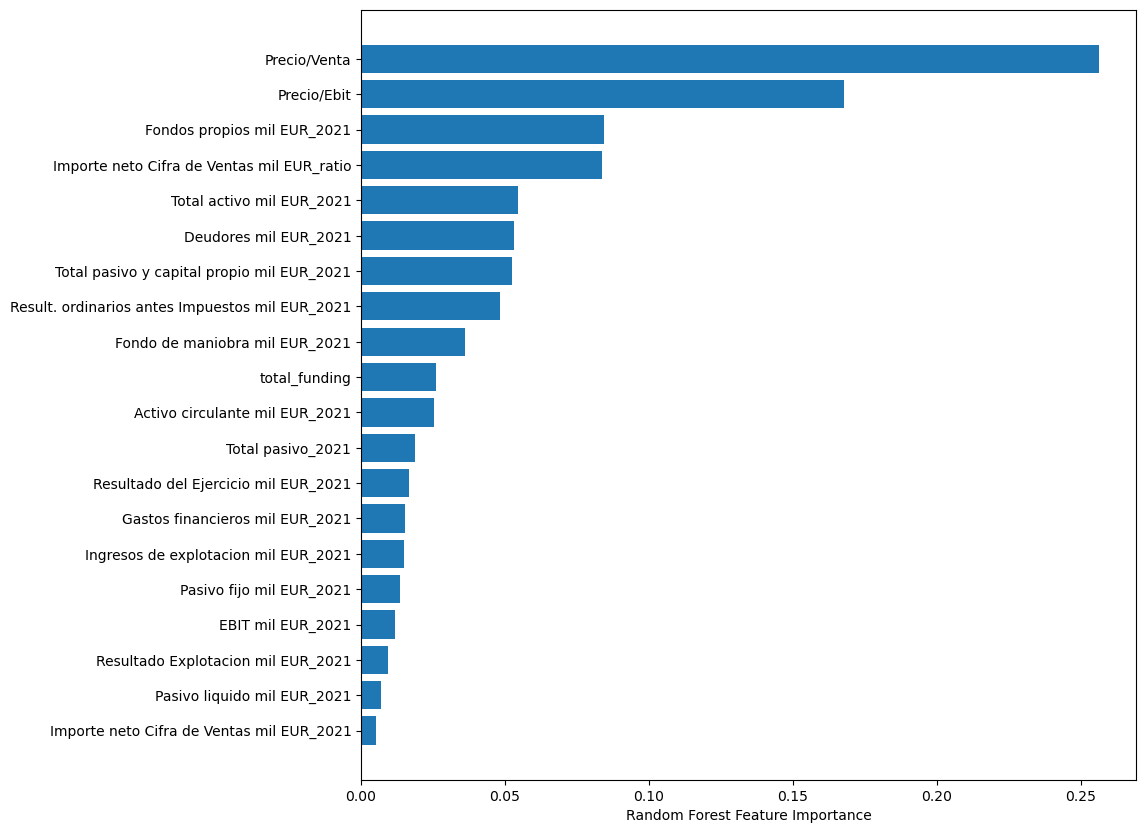

In [127]:
rf = RandomForestRegressor (random_state=0)
rf.fit(x_train, y_train)
print(dict(zip(DF_VALORACION.columns, rf.feature_importances_.round(2))))

forest_importances = pd.Series(rf.feature_importances_, index=DF_VALORACION.drop('valuation_2022', axis=1).columns).sort_values(ascending=True)
plt.figure(figsize=(10,10))
plt.barh(forest_importances.index, forest_importances)
plt.xlabel("Random Forest Feature Importance")

#Creacion de dataframe con importancia de caracteristicas forest_importances
forest_importances=forest_importances.to_frame().reset_index()
columns=['feature', 'importance']
forest_importances.columns=['feature', 'importance']
zero_features = list(forest_importances [forest_importances ['importance'] < 0.00025]['feature'])

In [147]:
space = {'criterion': hp.choice('criterion', ['poisson', 'friedman_mse', 'absolute_error', 'squared_error']),
         'max_depth': hp.quniform('max_depth', 10, 1200, 10),
         'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
         'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
         'min_samples_split': hp.uniform('min_samples_split', 0, 1),
         'n_estimators': hp.choice('n_estimators', [10, 50, 300, 750, 1200, 1300, 1500])
        }    

In [148]:
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    model = RandomForestRegressor(**params)
    score = -np.mean(cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
    return score

In [149]:
#Hyperparametros
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=80,
            trials=trials)
print("best: {}".format(best))

  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

job exception: name 'score' is not defined



  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]


NameError: name 'score' is not defined

In [144]:
best_params = {'criterion': 'friedman_mse',  'max_depth': 460, 'max_features': 2, 'min_samples_leaf': 0.0015884979809016805, 'min_samples_split': 0.3798658277164071, 'n_estimators': 2}

In [152]:
#Bagging Regressor con los mejores parametros
model = RandomForestRegressor(**best_params)
model.fit(x_train,y_train_scaled)
avg_mae8 = -scores.mean()

y_pred_scaled = model.predict(x_train)
y_pred =scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

mae8 = mean_absolute_error(y_train, y_pred)
r28 = r2_score(y_train, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae8}")
print(f"MAE: {mae8}")
print(f"R^2: {r28}")

Cross-validation MAE: 0.37233453365255437
MAE: 9.937673365600448
R^2: 0.6024354198889175


**Boosting**

In [129]:
#Boosting Regressor (AdaBoost)
model = AdaBoostRegressor(n_estimators=32,learning_rate=0.1)
scores = cross_val_score(model, x_train, y_train_scaled, cv=5, scoring='neg_mean_absolute_error')
avg_mae9 = -scores.mean()

# ajustar el modelo a todos los datos de entrenamiento
model.fit(x_train, y_train_scaled)
# hacer predicciones en los datos de prueba y desescalar las predicciones
y_pred_scaled = model.predict(x_train)
y_pred =scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

# evaluar el modelo en los datos de prueba
mae9 = mean_absolute_error(y_train, y_pred)
r29 = r2_score(y_train, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae9}")
print(f"MAE: {mae9}")
print(f"R^2: {r29}")

Cross-validation MAE: 0.4188700920720616
MAE: 3.7486728121008217
R^2: 0.9733261094777754


In [131]:
#Boosting Regressor (GradientBoosting)
model = GradientBoostingRegressor(n_estimators=32,learning_rate=0.1)
scores = cross_val_score(model, x_train, y_train_scaled, cv=5, scoring='neg_mean_absolute_error')
avg_mae10 = -scores.mean()

# ajustar el modelo a todos los datos de entrenamiento
model.fit(x_train, y_train_scaled)
# hacer predicciones en los datos de prueba y desescalar las predicciones
y_pred_scaled = model.predict(x_train)
y_pred =scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

# evaluar el modelo en los datos de prueba
mae10 = mean_absolute_error(y_train, y_pred)
r210 = r2_score(y_train, y_pred)

# imprimir los resultados
print(f"Cross-validation MAE: {avg_mae10}")
print(f"MAE: {mae10}")
print(f"R^2: {r210}")

Cross-validation MAE: 0.37233453365255437
MAE: 1.9820887865508388
R^2: 0.9934419533797046


In [85]:
#Definimos algunos modelos basicos
base_estimator = GradientBoostingRegressor()

param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [50, 100, 200,1000,2000],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'loss': ['huber', 'squared_error', 'quantile', 'absolute_error']
}

m10 = RandomizedSearchCV(base_estimator, param_distributions=param_dist, n_iter=100, cv=5, random_state=1, n_jobs=-1)
m10.fit(x_train, y_train)

#Gradien Boosting con los mejores parametros
best_params = m10.best_params_
m11 = GradientBoostingRegressor(max_depth=best_params['max_depth'], 
                                                learning_rate=best_params['learning_rate'], 
                                                n_estimators=best_params['n_estimators'], 
                                                min_samples_split=best_params['min_samples_split'], 
                                                min_samples_leaf=best_params['min_samples_leaf'], 
                                                loss=best_params['loss'], 
                                                random_state=1)
m11.fit(x_train, y_train)
y_pred=m11.predict(x_test)

mae11 = mean_absolute_error(y_test, y_pred)
r211 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae11}')
print(f'The r2 obtained on test data is: {r211}')

The MAE obtained on test data is: 15.237410512449435
The score obtained on test data is: -0.07187544805617407


In [86]:
#Guardamos el modelo
filename = 'modelo3_bor_level1_gs.sav'
ruta = './modelos_regresion/' + filename
pickle.dump(m11, open(ruta, 'wb'))

In [87]:
#cargamos el modelo y vemos resultados
filename = 'modelo3_bor_level1_gs.sav'
modelo3_bor_level1_gs_cargado = pickle.load(open('./modelos_regresion/'+ filename, 'rb'))
y_pred = modelo3_bor_level1_gs_cargado.predict(x_test)

mae12 = mean_absolute_error(y_test, y_pred)
r212 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae12}')
print(f'The r2 obtained on test data is: {r212}')

The MAE obtained on test data is: 15.237410512449435
The score obtained on test data is: -0.07187544805617407


**XGBoost**

In [88]:
#XGBoost Regressor
m13=XGBRegressor()
m13.fit(x_train,y_train)
y_predt=m13.predict(x_test)

mae13 = mean_absolute_error(y_test, y_pred)
r213 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae13}')
print(f'The r2 obtained on test data is: {r213}')

The MAE obtained on test data is: 15.237410512449435
The score obtained on test data is: -0.07187544805617407


In [89]:
#Define the parameter grid to search over
catboost_params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1,0.3],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [50, 100, 200],
    'border_count': [50, 100, 200],
    'random_strength': [0.1, 0.5, 1],
}

#XGBoost Regressor
m13=XGBRegressor()

m14 = GridSearchCV(
    estimator=m13,
    param_grid=catboost_params,
    n_jobs=-1,
    cv=5,
    verbose=3
)

#Fit the GridSearchCV object on the training data
m14.fit(x_train, y_train)
y_pred = m14.predict(x_test)

mae14 = mean_absolute_error(y_test, y_pred)
r214 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae14}')
print(f'The r2 obtained on test data is: {r214}')

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[21:24:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "border_count", "depth", "iterations", "l2_leaf_reg", "random_strength" } are not used.

The MAE obtained on test data is: 17.324176538944243
The score obtained on test data is: -0.13585660087933427


In [90]:
#Guardamos el modelo
filename = 'modelo3_bor_xgboost_gs.sav'
ruta = './modelos_regresion/' + filename
pickle.dump(m14, open(ruta, 'wb'))

In [92]:
#cargamos el modelo y vemos resultados
filename = 'modelo3_bor_xgboost_gs.sav'
modelo3_bor_xgboost_gs_cargado = pickle.load(open('./modelos_regresion/'+ filename, 'rb'))
y_pred = modelo3_bor_xgboost_gs_cargado.predict(x_test)

mae14 = mean_absolute_error(y_test, y_pred)
r214 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae14}')
print(f'The r2 obtained on test data is: {r214}')

The MAE obtained on test data is: 17.324176538944243
The score obtained on test data is: -0.13585660087933427


In [93]:
#CatBoost Regressor
m15=CatBoostRegressor()
m15.fit(x_train,y_train)
y_pred=m15.predict(x_test)

mae15 = mean_absolute_error(y_test, y_pred)
r215 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae15}')
print(f'The r2 obtained on test data is: {r215}')

Learning rate set to 0.025083
0:	learn: 27.8373252	total: 217ms	remaining: 3m 36s
1:	learn: 27.7088641	total: 218ms	remaining: 1m 48s
2:	learn: 27.4935543	total: 219ms	remaining: 1m 12s
3:	learn: 27.3213886	total: 220ms	remaining: 54.7s
4:	learn: 27.1899855	total: 220ms	remaining: 43.8s
5:	learn: 27.0077696	total: 221ms	remaining: 36.6s
6:	learn: 26.8285482	total: 222ms	remaining: 31.5s
7:	learn: 26.6652198	total: 223ms	remaining: 27.6s
8:	learn: 26.4826671	total: 223ms	remaining: 24.6s
9:	learn: 26.3252570	total: 224ms	remaining: 22.2s
10:	learn: 26.2267271	total: 225ms	remaining: 20.2s
11:	learn: 26.0840238	total: 226ms	remaining: 18.6s
12:	learn: 25.8721552	total: 227ms	remaining: 17.2s
13:	learn: 25.6996929	total: 228ms	remaining: 16s
14:	learn: 25.5224480	total: 228ms	remaining: 15s
15:	learn: 25.3633734	total: 229ms	remaining: 14.1s
16:	learn: 25.2420750	total: 230ms	remaining: 13.3s
17:	learn: 25.0420277	total: 231ms	remaining: 12.6s
18:	learn: 24.8382317	total: 232ms	remaining:

In [96]:
#Define the parameter grid to search over
catboost_params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1,0.3],
    'l2_leaf_reg': [1, 3, 5],

}

#CatBoost Regressor
m15 = CatBoostRegressor()

m16 = GridSearchCV(
    estimator=m15,
    param_grid=catboost_params,
    n_jobs=-1,
    cv=5,
    verbose=3
)

m16.fit(x_train, y_train)
y_pred = m16.predict(x_test)
mae16 = mean_absolute_error(y_test, y_pred)
r216 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae16}')
print(f'The r2 obtained on test data is: {r216}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 24.3186079	total: 8.02ms	remaining: 8.01s
1:	learn: 21.0505742	total: 8.75ms	remaining: 4.37s
2:	learn: 18.7781361	total: 9.3ms	remaining: 3.09s
3:	learn: 16.8749074	total: 9.93ms	remaining: 2.47s
4:	learn: 14.7988809	total: 11.1ms	remaining: 2.21s
5:	learn: 13.2646262	total: 12ms	remaining: 1.99s
6:	learn: 11.7699778	total: 12.8ms	remaining: 1.81s
7:	learn: 10.8107875	total: 13.2ms	remaining: 1.64s
8:	learn: 9.8159451	total: 13.7ms	remaining: 1.51s
9:	learn: 8.4080574	total: 14.2ms	remaining: 1.41s
10:	learn: 7.7172773	total: 14.7ms	remaining: 1.32s
11:	learn: 6.8366140	total: 15.3ms	remaining: 1.26s
12:	learn: 6.1608791	total: 15.8ms	remaining: 1.2s
13:	learn: 5.2627590	total: 16.2ms	remaining: 1.14s
14:	learn: 4.6165888	total: 16.7ms	remaining: 1.1s
15:	learn: 4.0923285	total: 17.3ms	remaining: 1.06s
16:	learn: 3.6636054	total: 17.8ms	remaining: 1.03s
17:	learn: 3.2079176	total: 18.3ms	remaining: 996ms
18:	learn

In [97]:
#Guardamos el modelo
filename = 'modelo3_bor_catboost_gs.sav'
ruta = './modelos_regresion/' + filename
pickle.dump(m16, open(ruta, 'wb'))

In [98]:
#cargamos el modelo y vemos resultados
filename = 'modelo3_bor_catboost_gs.sav'
modelo3_bor_catboost_gs_cargado = pickle.load(open('./modelos_regresion/'+ filename, 'rb'))
y_pred = modelo3_bor_catboost_gs_cargado.predict(x_test)

mae16 = mean_absolute_error(y_test, y_pred)
r216 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae16}')
print(f'The r2 obtained on test data is: {r216}')

The MAE obtained on test data is: 16.412457475021785
The r2 obtained on test data is: -0.013453041567399682


**Automated Machine Learning (AutoML)**

In [100]:
#Realizamos un TPOT para ver si podemos mejorar los resultados
m17 = TPOTRegressor(generations=5, population_size=50, verbosity=2, n_jobs=-1)
m17.fit(x_train, y_train)
y_pred=m17.predict(x_test)

mae17 = mean_absolute_error(y_test, y_pred)
r217 = r2_score(y_test, y_pred)

print(f'The MAE obtained on test data is: {mae17}')
print(f'The r2 obtained on test data is: {r217}')

                                                                             
Generation 1 - Current best internal CV score: -425.39594461434234
                                                                              
Generation 2 - Current best internal CV score: -368.7364257956883
                                                                              
Generation 3 - Current best internal CV score: -368.7364257956883
                                                                              
Generation 4 - Current best internal CV score: -368.7364257956883
                                                                              
Generation 5 - Current best internal CV score: -368.7364257956883
                                                                              
Best pipeline: LinearSVR(AdaBoostRegressor(input_matrix, learning_rate=0.001, loss=exponential, n_estimators=100), C=25.0, dual=True, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.001)
T

**RESULTADOS**

In [101]:
models = pd.DataFrame([
    {'Model': 'Linear Regression', 'MAE': mae1, 'Score': r21},
    {'Model': 'Tweddie Regression', 'MAE': mae2, 'Score': r22},
    {'Model': 'Stacking Regressor Simple:', 'MAE': mae3, 'Score': r23},
    {'Model': 'Stacking Regressor Level1', 'MAE': mae4, 'Score': r24},
    {'Model': 'Stacking Regressor Level2', 'MAE': mae6, 'Score': r26},
    {'Model': 'Stacking Regressor Level2 Grid Search', 'MAE': mae7, 'Score': r27},
    {'Model': 'Bagging Regressor (RandomForest)', 'MAE': mae8, 'Score': r28},
    {'Model': 'Bagging Regressor (RandomForest) Optimizado', 'MAE': mae9, 'Score': r29},
    {'Model': 'Boosting Regressor (AdaBoost)', 'MAE': mae10, 'Score': r210},
    {'Model': 'Boosting Regressor (GradientBoost)', 'MAE': mae11, 'Score': r211},
    {'Model': 'Boosting Regressor (GradientBoost) Grid Search', 'MAE': mae12, 'Score': r211},
    {'Model': 'XGBoost', 'MAE': mae13, 'Score': r213},
    {'Model': 'XGBoost Grid Search', 'MAE': mae14, 'Score': r214},
    {'Model': 'CatBoost', 'MAE': mae15, 'Score': r215},
    {'Model': 'CatBoost Grid Search', 'MAE': mae15, 'Score': r216},
    {'Model': 'AutoML', 'MAE': mae17, 'Score': r217}
])
models.sort_values(by='MAE', ascending=False)

,Model,MAE,Score
1,Tweddie Regression,28.016859,-0.540078
0,Linear Regression,18.654234,-0.179821
15,AutoML,18.539180,-0.018214
12,XGBoost Grid Search,17.324177,-0.135857
2,Stacking Regressor Simple:,17.231912,0.161598
4,Stacking Regressor Level2,16.960517,-0.138519
9,Boosting Regressor (GradientBoost),15.237411,-0.071875
10,Boosting Regressor (GradientBoost) Grid Search,15.237411,-0.071875
11,XGBoost,15.237411,-0.071875
6,Bagging Regressor (RandomForest),14.752667,-0.134874
